# 概要
如果对上万个随机的人提问，得到的解集，在大多数情况下好过一个专家给出的解，这就叫群众的智慧。  
相似地，如果使用若干个预测器，得到的综合结果也往往好过一个单独预测器。这组预测器称为集成，这种技术称为集成学习，集成学习的算法称为集成方法。 比如我们可以训练一组决策树，将训练输出结果按照投票方式组合，这种方法就是随机森林。  
一般工程将集成方法放在工程结束时使用，对手头上已经训练好的若干不错的预测器进行集成。  
# 投票分类
假设现在有若干个正确率80%的分类器，大概包括逻辑分类，SVM分类，随机森林，k近邻分类等，一个非常简单的办法将他们集成，就是将结果按多数投票的办法。这种按照多数投票的分类器称为硬投票分类器。实际上集成方法可以将弱分类器(只比随机结果略好)集成为强分类器:这就像是多个正面向上51%的硬币投币的结果一样。

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

X, y = make_moons(n_samples=300, noise=0.1,random_state=42)
scaler = StandardScaler()
scaler.fit_transform(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y)

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf) ,('rf', rnd_clf), ('svc',svm_clf)],
    voting='hard',
)

LogisticRegression 0.866666666667
RandomForestClassifier 0.986666666667
SVC 0.973333333333
VotingClassifier 0.973333333333


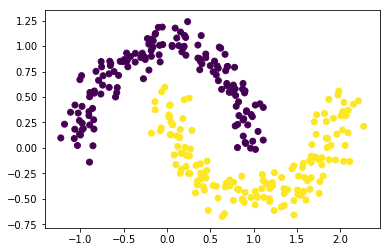

In [39]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__,accuracy_score(y_test, y_pred))
    
plt.scatter(X[:,0], X[:,1], c=y)

# 包装和粘贴
一个方法去获得多样化的分类器是使用不同的算法，另一种方法是，使用同一种方法，但是用不同的训练子集去训练它们。如果采样是不放回的称为bagging，采样是放回的称为pasting.  
换句话说，它们都允许训练样例多次采样供给多个预测器，其中bagging允许训练样例被同一个预测器多次采样。一旦训练完成，就可以将它们集成在一起，集成函数是典型的分类统计模式，或者回归的平均数值。每个单独的预测器都比训练集偏差更大，但是集成会减小偏差和方差。一般来说集成后的模型偏差和各个预测器相近，方差更小。
若干个预测器可以同时并行训练。

In [40]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier()
bag_clf = BaggingClassifier(
        DecisionTreeClassifier(), n_estimators=500,
        max_samples=50, bootstrap=True, n_jobs=-1
    )
tree_clf.fit(X_train,y_train)
bag_clf.fit(X_train, y_train)


BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=50, n_estimators=500, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

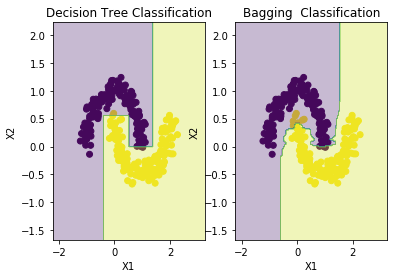

In [43]:
import numpy as np
# Plotting decision regions

# Predict
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

y_predict_tree = tree_clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
y_predict_bag = bag_clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)


# Plot the results
plt.figure()
plt.subplot(121)
plt.scatter(X[:,0], X[:,1], c=y)
plt.contourf(xx, yy, y_predict_tree, alpha=0.3)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Decision Tree Classification")

plt.subplot(122)
plt.scatter(X[:,0], X[:,1], c=y)
plt.contourf(xx, yy, y_predict_bag, alpha=0.3)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Bagging  Classification")


plt.show()

Bootstrapping 使每个单独预测器的训练集更加多样化。所以结果使得bagging相比pasting有更高的偏差，但是也意味着预测器更少地相关性，从而使方差变小，总之bagging经常能够给出不错的结果。如果有空余时间也可以尝试pasting再比较。
# 包外评估  
bagging方法在默认值bootstrap=true的情况下，训练集有大约百分37的数据是没有用作训练的。他们被称为包外数据(oob,out-of-bag)，所以bagging方法是不需要cv的。  
sklearn中设置oob_score=True，就可以自动得到包外评估值，

In [47]:
bag_clf = BaggingClassifier(
        DecisionTreeClassifier(), n_estimators=500,
        bootstrap=True, n_jobs=-1, oob_score=True
    )
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.98222222222222222

In [48]:
#返回每个样例的概率
bag_clf.oob_decision_function_

array([[ 0.        ,  1.        ],
       [ 1.        ,  0.        ],
       [ 0.        ,  1.        ],
       [ 0.90052356,  0.09947644],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 0.        ,  1.        ],
       [ 1.        ,  0.        ],
       [ 0.        ,  1.        ],
       [ 0.59116022,  0.40883978],
       [ 0.05464481,  0.94535519],
       [ 0.        ,  1.        ],
       [ 0.        ,  1.        ],
       [ 0.        ,  1.        ],
       [ 0.97252747,  0.02747253],
       [ 0.99435028,  0.00564972],
       [ 1.        ,  0.        ],
       [ 0.03723404,  0.96276596],
       [ 0.        ,  1.        ],
       [ 0.        ,  1.        ],
       [ 1.        ,  0.        ],
       [ 0.        ,  1.        ],
       [ 0.        ,  1.        ],
       [ 1.        ,  0.        ],
       [ 0.        ,  1.        ],
       [ 0.        ,  1.        ],
       [ 0.93820225,  0.06179775],
       [ 0.        ,  1.        ],
       [ 0.08333333,

# Random Patches and Random Subspaces
bagging可以很好的支持特征采样，这样，每个预测器就按照输入特征随机生成子集。这对于处理高维输入，比如图片数据非常有用。按照训练样例和特征的采样方法称为random patches。保持样例，而只采样特征的方法称为random subspaces。  
特征采样的结果是使预测器更加多样化。
# 随机森林
随机森林通过bagging方法，max_samples设置成训练集大小将决策树bagging。

In [49]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

随机森林包含所有决策树的超参数，和bagging的超参数  
随机森林算法引入额外的随机性当生成树时。它不是按照最佳特征划分节点，而是在随机的特征子集中搜索最佳特征，这使得树更加多样化，同时也导致更大的偏差和更小的方差，

# Extra-Trees
在随机森林中生成树时，每个节点只有一个用来划分的特征子集。这使得对于每个特征都加入了随机的阈值，而不是像普通的决策树一样，搜索一个可能最佳的阈值组。  
这种方法随机森林的生成方法为极度随机树集成Extremly Randomized Trees(或者称为额外树Extra-Trees),由于不需要计算最佳划分，所以生成速度快于一般的决策树。  
可以使用extratreeclassifier来应用它。
# 特征偏重
如果单看一个决策树，重要的特征大致都接近树根。所以我们可以使用特征在森林中的平均深度来估计他们的重要性

In [50]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'],iris['target'])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.0937925782702
sepal width (cm) 0.0247682178971
petal length (cm) 0.433990244489
petal width (cm) 0.447448959344


随机森林是一个很容易着手的判断特征重要性的手段。
# Boosting
boosting提升方法又称hypothesis boosting(假设提升)，是指一类将弱学习器集成为强学习器的方法，一般看来boosting方法，就是以训练一系列预测器，每个都尝试在前一个上面提高，有很多可选的boost算法，最出名的是adaboost
## Adaboost
一个提升办法就是使用导致前一个预测器欠拟合的样例去修正预测器，这使得新预测器更加关注复杂情况。这就叫Adaboost。  
我们使前一个预测器错误的样例值权重提高，这使用学习率控制。这种序列化学习提升手段类似于梯度下降。一旦训练完成，同样使用bagging或者pasting.而可以不计他们的权重值。(一个问题是它们不能并行训练，结果导致他们不能被bagging或者pasting优化。  
我们使用数学表达式看看怎么实现：  
初始条件下:每个样例的权值$\mathbf w^{(i)}$被设置为$\frac{1}{m}$。第一个预测器训练完成后他的权重误差$r_1$就被计算出来：  
$r_j=\frac{\sum_{i=1,\hat y_j^{(i)}\ne y^{(i)}}^m\mathbf w^{(i)}}{\sum_{i=1}^m\mathbf w^{(i)}}\text{   这里 $\hat y_j^{(i)}$是第j个预测器对于样例i的预测值 } $  
预测器的权重$\alpha_j$就能由此得出，其中$\eta$是学习率，默认为1，预测器的准确度越高，权重就越高，如果预测器是瞎猜型，权重就接近为0，如果越策器比瞎猜还差，相当于大多情况下错误，权值为负、  
$\alpha_j=\eta log\frac{1-r_j}{r_j}$  
接下来就是更新权重，错误分类的样例被更新：   
$for\quad i=1,2,\cdots,m\\
\mathbf w^{(i)}\leftarrow\left{
\begin{array}{ll}
\mathbf w^{(i)}&\text{if }\hat y_j^{(i)}=y^{(i)}\\
\mathbf w^{(i)}exp(\alpha_j)&\text{if }\hat y_j^{(i)}\ne y^{(i)}
\end{array}
\right.$  
这样便得到标准化后的样例权重(除以所有权值和)  
最后新的预测器就使用更新后的权值预测出来，如此往复。直到预测器数目达到预期值或者最优预测器被找到。  
  
adaboost做预测时，使用所有预测器和它们的权值$\alpha_j$,预测结果是其中权值和预计值的总和取多数投票值。
$\hat y(x) = argmax_k\sum_{j=1,\hat y_j(x)=k}^N\alpha_j$其中N是预测器数目  
sklearn使用了多种adaboost的版本就做SAMME.当只有两个类时，SAMME就是adaboost。如果预测器有对于结果的概率，可以使用SAMME的方差SAMME.R，他基于每个预测概率，因此能得到更好的结果。  
Adaboost默认的基础分类器是决策树桩，即最大深度为1的决策树:  

In [52]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=1), n_estimators=200,
        algorithm="SAMME.R", learning_rate=0.5
)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=None)

如果Adaboost过拟合，可以减少预测器数目，或者使正则化效果更强的基学习器。

## Gradient Boosting
另一个流行的boost算法是Gradient boosting。同样也是训练一序列预测器，后者是前者的修正版预测器。这里修正前者产生的残差而不是修改权重来实现。使用这种算法并且基于决策树实现的，称为Gradient Boosted Regression Tree(GBRT)或者Gradient Tree Boosting  
其实就是不断的使用决策树去适应前者的残差，最后得到的预测器是所有预测值的综合。  
其中的学习率超参数是用来调整每个树对结果的贡献值。如果设置低，就需要更多的树去集成，但是也能得到更好的结果。这种技术叫做收缩Shrinkage。  
为了得到最优的树的数目，可以提前中断学习，使用staged_predict()方法。

28


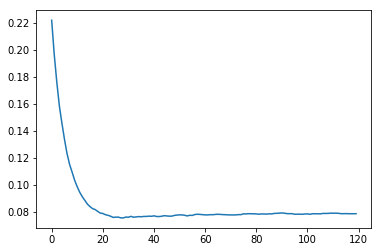

In [62]:
import numpy as np 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_moons


X, y = make_moons(n_samples=300, noise=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

grbt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
grbt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
         for y_pred in grbt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

print(bst_n_estimators)

grbt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators,random_state=42)
grbt_best.fit(X_train, y_train)

plt.plot(errors)

另一种方法是真正意义上的提前结束，从而避免训练一个很多模型再从头寻找合适的值

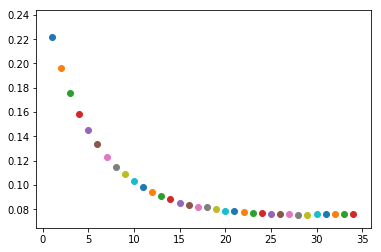

In [63]:
grbt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    grbt.n_estimators = n_estimators
    grbt.fit(X_train, y_train)
    y_pred = grbt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    plt.scatter(n_estimators, val_error)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break

BradientBoosting 还支持subsample超参数，用来控制每个树的训练集比例。如果其为0.25,那么每棵树就从训练集随机抽取百分25的样例来训练，这也会导致偏差变大，但是方差减小。可以增快学习。这就是随机梯度提升算法Stochastic Gradient Boosting.  
Gb算法还可以应用不同的损失函数算法，通过修改loss参数实现。
## stacking
最后一种集成方法是堆叠stacking(stacked generalization的简称)。他是基于下面的思想:使用一个模型blender去替代类似投票的函数，将所有预测器(meta)的结果整合。通过这种方法，还能建立多层结构。  
sklearn并不支持stacking方法，但是可以自己实现它。